# B5W3: End-to-End Insurance Risk Analytics & Predictive Modeling
## Task 4
    - Build and evaluate predictive models

In [114]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore') # Filter out some common warnings for cleaner output

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_auc_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import shap 
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from xgboost import XGBClassifier

In [115]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [116]:
df  = pd.read_csv('../data/MachineLearningRating_v3.csv', low_memory=False )

In [117]:
from scripts.data_converter import DataConverter

#### Missing values

In [118]:
df.isnull().sum()

UnderwrittenCoverID               0
PolicyID                          0
TransactionMonth                  0
IsVATRegistered                   0
Citizenship                       0
LegalType                         0
Title                             0
Language                          0
Bank                         145961
AccountType                   40232
MaritalStatus                  8259
Gender                         9536
Country                           0
Province                          0
PostalCode                        0
MainCrestaZone                    0
SubCrestaZone                     0
ItemType                          0
mmcode                          552
VehicleType                     552
RegistrationYear                  0
make                            552
Model                           552
Cylinders                       552
cubiccapacity                   552
kilowatts                       552
bodytype                        552
NumberOfDoors               

In [ ]:
# --- Strategy Implementation ---

# 1. Identify and drop columns with very high missingness (> 60%)
columns_to_drop = [
    'NumberOfVehiclesInFleet',
    'CrossBorder',
    'CustomValueEstimate',
    'WrittenOff',
    'Rebuilt',
    'Converted'
]
df_cleaned = df.drop(columns=columns_to_drop)
print(f"Dropped {len(columns_to_drop)} columns with high missing data.")

# 2. Drop rows with low missingness (< 5%)
# This is a safe and clean approach for columns like Gender, MaritalStatus, and vehicle details
# We'll drop rows where any of these columns have a missing value.
rows_to_drop_na = [
    'Gender',
    'MaritalStatus',
    'CapitalOutstanding',
    'mmcode', 'VehicleType', 'make', 'Model', 'Cylinders', 'cubiccapacity',
    'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate'
]

# Create a copy to avoid SettingWithCopyWarning
df_cleaned = df_cleaned.dropna(subset=rows_to_drop_na).copy()
print(f"Dropped rows with missing values in key low-missingness columns.")
print(f"Remaining rows after dropping: {df_cleaned.shape[0]}")

# 3. Impute columns with moderate missingness (5-30%)
# These columns are `Bank`, `AccountType`, and `NewVehicle`
# Let's check their data types to choose the right imputation strategy
# `Bank` and `AccountType` are likely categorical. `NewVehicle` is likely binary.
# We will use the `most_frequent` (mode) strategy.

imputation_features = ['Bank', 'AccountType', 'NewVehicle']
imputer = SimpleImputer(strategy='most_frequent')

# The imputer needs to be fitted on the data
df_cleaned[imputation_features] = imputer.fit_transform(df_cleaned[imputation_features])
print("Imputed missing values in 'Bank', 'AccountType', and 'NewVehicle' with the mode.")

# Final check of missing values after cleaning
print("\nFinal Missing Value Summary:")
print(df_cleaned.isnull().sum().sort_values(ascending=False))

# Update  `modeling_features` list to reflect the changes
modeling_features = [
    'Province', 'Gender', 'make', 'body_type', 'Cylinders', 'VehicleAge',
    'CapitalOutstanding', 'SumInsured', 'CalculatedPremiumPerTerm',
    'Bank', 'AccountType', 'NewVehicle', 'MaritalStatus' # Add imputed features
]
# Note: 'Model' is a high-cardinality feature. We will handle it with one-hot encoding later.
# You might need to add `cubiccapacity`, `kilowatts`, and `NumberOfDoors` if you want to use them.

Dropped 6 columns with high missing data.
Dropped rows with missing values in key low-missingness columns.
Remaining rows after dropping: 989557
Imputed missing values in 'Bank', 'AccountType', and 'NewVehicle' with the mode.

Final Missing Value Summary:
UnderwrittenCoverID         0
PolicyID                    0
TransactionMonth            0
IsVATRegistered             0
Citizenship                 0
LegalType                   0
Title                       0
Language                    0
Bank                        0
AccountType                 0
MaritalStatus               0
Gender                      0
Country                     0
Province                    0
PostalCode                  0
MainCrestaZone              0
SubCrestaZone               0
ItemType                    0
mmcode                      0
VehicleType                 0
RegistrationYear            0
make                        0
Model                       0
Cylinders                   0
cubiccapacity           

#### Feature Engineering

In [120]:
# Create a copy to perform feature engineering without modifying the original DataFrame
df_fe = df.copy()

# 1. Vehicle Age
# This is a classic risk feature, as older vehicles may have different risk profiles.
# We'll calculate it relative to the latest registration year in the data.
max_reg_year = df_fe['RegistrationYear'].max()
df_fe['VehicleAge'] = max_reg_year - df_fe['RegistrationYear']
print(f"Created 'VehicleAge' based on RegistrationYear. Max age is {df_fe['VehicleAge'].max()} years.")

# 2. Premium Rate (a proxy for risk density)
# This ratio captures the premium paid relative to the sum insured.
# A higher rate might indicate a policy the insurer already considered higher risk.
# Handle division by zero/missing SumInsured to avoid errors
df_fe['PremiumRate'] = df_fe['CalculatedPremiumPerTerm'] / df_fe['SumInsured'].replace(0, np.nan)
# Replace infinite values with NaN and then a sensible number like the median
df_fe['PremiumRate'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_fe['PremiumRate'].fillna(df_fe['PremiumRate'].median(), inplace=True)
print("Created 'PremiumRate' (CalculatedPremiumPerTerm / SumInsured).")

# 3. Under/Over-Insurance Ratio
# This compares the policy's sum insured to the vehicle's estimated value,
# which could be a proxy for customer behavior or risk.
# Handle division by zero/missing CustomValueEstimate
df_fe['SumInsuredRatio'] = df_fe['SumInsured'] / df_fe['CustomValueEstimate'].replace(0, np.nan)
df_fe['SumInsuredRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_fe['SumInsuredRatio'].fillna(df_fe['SumInsuredRatio'].median(), inplace=True)
print("Created 'SumInsuredRatio' (SumInsured / CustomValueEstimate).")

# 4. Binning a numerical feature (e.g., VehicleAge)
# This converts a continuous variable into categorical bins, which can help models
# capture non-linear relationships without needing a complex model.
df_fe['VehicleAgeGroup'] = pd.cut(
    df_fe['VehicleAge'],
    bins=[0, 5, 10, 15, 20, np.inf],
    labels=['0-5 Years', '6-10 Years', '11-15 Years', '16-20 Years', '20+ Years'],
    right=False
)
print("Created 'VehicleAgeGroup' by binning VehicleAge.")

# 5. Interaction Feature (example)
# This can capture that a combination of factors might be a better predictor than
# each factor alone (e.g., older vehicles of a specific make).
df_fe['Make_VehicleAge'] = df_fe['make'].astype(str) + '_' + df_fe['VehicleAgeGroup'].astype(str)
print("Created 'Make_VehicleAge' interaction feature.")

print("\nFeature Engineering is complete.")

Created 'VehicleAge' based on RegistrationYear. Max age is 28 years.
Created 'PremiumRate' (CalculatedPremiumPerTerm / SumInsured).
Created 'SumInsuredRatio' (SumInsured / CustomValueEstimate).
Created 'VehicleAgeGroup' by binning VehicleAge.
Created 'Make_VehicleAge' interaction feature.

Feature Engineering is complete.


#### Update Modeling Pipeline

In [ ]:
# Update the list of features for  modeling pipeline
modeling_features_updated = [
    # Original Features
    'Province', 'Gender', 'make', 'Model', 'body_type', 'Cylinders', 'RegistrationYear',
    'CustomValueEstimate', 'CapitalOutstanding', 'SumInsured', 'CalculatedPremiumPerTerm',
    'NumberOfDoors', 'AlarmImmobiliser', 'TrackingDevice', 'CoverType',
    
    # Engineered Features
    'VehicleAge',           # Numerical
    'PremiumRate',          # Numerical
    'SumInsuredRatio',      # Numerical
    'VehicleAgeGroup',      # Categorical
    'Make_VehicleAge'       # Categorical (Interaction)
]

# Note: You will need to re-run the missing data handling and encoding steps on `df_fe`
# with this updated list of features.

#### Identify Categorical and Numerical Features

In [ ]:
# Identify all categorical and numerical columns in the engineered DataFrame `df_fe`
# We'll re-run the missing data handling and feature engineering to ensure we use the correct DataFrame.
# (This is just a repeat of the necessary setup for continuity)
# Let's assume you've executed the previous steps and have a `df_fe` DataFrame.
# We'll handle missing values here again before encoding for a clean pipeline.
# Impute with the mode
imputer = SimpleImputer(strategy='most_frequent')
imputation_features = ['Bank', 'AccountType', 'NewVehicle', 'Gender', 'MaritalStatus']
df_fe[imputation_features] = imputer.fit_transform(df_fe[imputation_features])
# Drop rows with low missingness (e.g., in vehicle features)
rows_to_drop_na = ['make', 'Model', 'bodytype', 'Cylinders']
df_fe.dropna(subset=rows_to_drop_na, inplace=True)
df_fe['VehicleAge'] = df_fe['RegistrationYear'].max() - df_fe['RegistrationYear'] # Re-create VehicleAge

# Define the final lists of features for encoding and scaling
categorical_features = ['Province', 'Gender', 'make', 'bodytype', 'Cylinders', 'AlarmImmobiliser', 'TrackingDevice',
                        'CoverType', 'Bank', 'AccountType', 'MaritalStatus', 'NewVehicle', 'CoverCategory', 'CoverGroup',
                        'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType']
numerical_features = ['VehicleAge', 'CustomValueEstimate', 'CapitalOutstanding', 'SumInsured',
                      'CalculatedPremiumPerTerm', 'ExcessSelected', 'TotalPremium', 'TotalClaims']

# Note: We've excluded high-cardinality features like 'Model' from this list for simplicity.
# Encoding 'Model' would create hundreds of columns. You can add it if  machine can handle it.
print("Identified categorical and numerical features.")

Identified categorical and numerical features.


In [123]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999546 entries, 0 to 1000097
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   UnderwrittenCoverID       999546 non-null  int64   
 1   PolicyID                  999546 non-null  int64   
 2   TransactionMonth          999546 non-null  object  
 3   IsVATRegistered           999546 non-null  bool    
 4   Citizenship               999546 non-null  object  
 5   LegalType                 999546 non-null  object  
 6   Title                     999546 non-null  object  
 7   Language                  999546 non-null  object  
 8   Bank                      999546 non-null  object  
 9   AccountType               999546 non-null  object  
 10  MaritalStatus             999546 non-null  object  
 11  Gender                    999546 non-null  object  
 12  Country                   999546 non-null  object  
 13  Province                  999546 

#### Implement One-Hot Encoding

In [124]:
# Define the lists of features for our preprocessing pipeline
# These lists should contain all the features you want to use for modeling.

# Categorical Features (Nominal)
categorical_features = [
    'Province', 'Gender', 'make', 'bodytype', 'Cylinders', 'AlarmImmobiliser',
    'TrackingDevice', 'CoverType', 'CoverCategory', 'CoverGroup', 'Section',
    'Product', 'StatutoryClass', 'StatutoryRiskType', 'Title', 'Language',
    'Bank', 'AccountType', 'MaritalStatus', 'ItemType', 'VehicleType',
    'NewVehicle', 'VehicleAgeGroup' # Includes the binned feature from engineering
]

# Numerical Features (Continuous or Discrete)
numerical_features = [
    'VehicleAge', 'CustomValueEstimate', 'CapitalOutstanding', 'SumInsured',
    'CalculatedPremiumPerTerm', 'ExcessSelected', 'TotalPremium', 'TotalClaims',
    'TermFrequency', 'NumberOfDoors', 'cubiccapacity', 'kilowatts',
    'PremiumRate', # The engineered feature
]

# Exclude high-cardinality features like 'Model' or 'PostalCode' to avoid a massive number of columns.
# You can add them back if needed, but be aware of the impact on performance.

In [ ]:
# --- STEP 1: LOAD  DATA (Make sure  DataFrame is named 'df') ---
# Assuming you have already loaded  DataFrame 'df' from a CSV or other source.
# Example: df = pd.read_csv('_data.csv')

# --- STEP 2: CRITICAL - CLEAN FINANCIAL COLUMNS FIRST ---
# This must be run on the DataFrame at the very beginning to fix the comma issue.
financial_columns_to_fix = [
    'CalculatedPremiumPerTerm', 'SumInsured', 'TotalPremium', 'TotalClaims',
    'CustomValueEstimate', 'CapitalOutstanding', 'ExcessSelected'
]

def clean_and_convert_columns(df, columns):
    """
    Cleans string columns by replacing commas with dots and converts them to numeric.
    Handles non-convertible values by coercing them to NaN.
    """
    for col in columns:
        if col in df.columns:
            # Ensure the column is treated as a string to use .str accessor
            df[col] = df[col].astype(str)
            
            # Replace the comma with a dot and convert to numeric
            df[col] = pd.to_numeric(df[col].str.replace(',', '.', regex=False), errors='coerce')
    return df

# Apply the cleaning function to  DataFrame
df = clean_and_convert_columns(df, financial_columns_to_fix)
print("Step 2: Financial columns cleaned and converted to numerical types.")


# --- STEP 3: CREATE THE TARGET VARIABLE AND PERFORM FEATURE ENGINEERING ---
df['ClaimOccurred'] = np.where(df['TotalClaims'] > 0, 1, 0)
max_reg_year = df['RegistrationYear'].max()
df['VehicleAge'] = max_reg_year - df['RegistrationYear']
df['PremiumRate'] = df['CalculatedPremiumPerTerm'] / df['SumInsured'].replace(0, np.nan)
df['PremiumRate'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['PremiumRate'].fillna(df['PremiumRate'].median(), inplace=True)
print("Step 3: Target variable and engineered features created.")


# --- STEP 4: HANDLE MISSING DATA (Imputation/Dropping) ---
# Create a copy for cleaning and preprocessing
df_fe = df.copy()

# Drop rows with low missingness (e.g., in vehicle features)
rows_to_drop_na = ['make', 'Model', 'bodytype', 'Cylinders']
df_fe.dropna(subset=rows_to_drop_na, inplace=True)

# Impute columns with moderate missingness
imputation_features = ['Bank', 'AccountType', 'NewVehicle', 'Gender', 'MaritalStatus']
imputer = SimpleImputer(strategy='most_frequent')

# Iterate through the columns to impute
for col in imputation_features:
    if col in df_fe.columns:
        # Fit and transform the data and flatten the output array before assignment
        df_fe[col] = imputer.fit_transform(df_fe[[col]]).ravel()
        
print("Imputed missing values in 'Bank', 'AccountType', 'NewVehicle', 'Gender', and 'MaritalStatus'.")


# --- STEP 5: ENCODING & SCALING ---
# Define features after all previous steps
categorical_features = ['Province', 'Gender', 'make', 'bodytype', 'Cylinders', 'AlarmImmobiliser',
                        'TrackingDevice', 'CoverType', 'Bank', 'AccountType', 'MaritalStatus',
                        'NewVehicle']
numerical_features = ['VehicleAge', 'CapitalOutstanding', 'SumInsured',
                      'CalculatedPremiumPerTerm', 'ExcessSelected', 'TotalPremium',
                      'TotalClaims', 'PremiumRate']

# Define the features (X) and target (y) from the clean DataFrame
X_all = df_fe[categorical_features + numerical_features]
y_freq = df_fe['ClaimOccurred']

# Create the preprocessor pipeline
# Redefine  preprocessor with an imputer in each pipeline
# This is the industry-standard way to handle imputation and prevent data leakage.
preprocessor = ColumnTransformer(
    transformers=[
        # Pipeline for NUMERICAL features: Impute with median, then scale
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        
        # Pipeline for CATEGORICAL features: Impute with mode, then encode
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ])

# Now, re-run this line. It will now handle the NaNs automatically.
X_processed = preprocessor.fit_transform(X_all)

print("\nPreprocessor updated to handle NaNs within the pipeline.")
print("X_processed has been successfully created without missing values.")


# --- STEP 6: TRAIN-TEST SPLIT ---
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(
    X_processed,      #  processed features
    y_freq,           #  target variable
    test_size=0.3,    # 30% of the data for testing
    random_state=42,  # For reproducibility
    stratify=y_freq   # Maintain class distribution
)

print("\nStep 6: Data has been successfully split into training and testing sets.")
print(f"X_train_freq shape: {X_train_freq.shape}")
print(f"y_train_freq shape: {y_train_freq.shape}")
print(f"X_test_freq shape: {X_test_freq.shape}")
print(f"y_test_freq shape: {y_test_freq.shape}")

Step 2: Financial columns cleaned and converted to numerical types.
Step 3: Target variable and engineered features created.
Imputed missing values in 'Bank', 'AccountType', 'NewVehicle', 'Gender', and 'MaritalStatus'.

Preprocessor updated to handle NaNs within the pipeline.
X_processed has been successfully created without missing values.

Step 6: Data has been successfully split into training and testing sets.
X_train_freq shape: (699682, 130)
y_train_freq shape: (699682,)
X_test_freq shape: (299864, 130)
y_test_freq shape: (299864,)


In [126]:
log_reg_model = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_freq, y_train_freq)
rf_clf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train_freq, y_train_freq)
xgb_clf_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss').fit(X_train_freq, y_train_freq)

# --- 1. Logistic Regression (Linear Classifier) ---
print("Training Logistic Regression model...")
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_freq, y_train_freq)

print("Logistic Regression training complete.")



Training Logistic Regression model...
Logistic Regression training complete.


In [127]:
# --- 2. Random Forest Classifier ---
print("\nTraining Random Forest Classifier...")
rf_clf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf_model.fit(X_train_freq, y_train_freq)
print("Random Forest Classifier training complete.")

# --- 3. XGBoost Classifier ---
try:
    from xgboost import XGBClassifier
    print("\nTraining XGBoost Classifier...")
    # `use_label_encoder` and `eval_metric` are set to suppress warnings in older versions
    xgb_clf_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    xgb_clf_model.fit(X_train_freq, y_train_freq)
    print("XGBoost Classifier training complete.")
    models_to_evaluate = [log_reg_model, rf_clf_model, xgb_clf_model]
    model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
except ImportError:
    print("\nWarning: XGBoost is not installed. Skipping XGBoost model.")
    models_to_evaluate = [log_reg_model, rf_clf_model]
    model_names = ['Logistic Regression', 'Random Forest']


Training Random Forest Classifier...
Random Forest Classifier training complete.

Training XGBoost Classifier...
XGBoost Classifier training complete.


In [131]:
# Define the features (X) and target (y)
X_all = df_fe[categorical_features + numerical_features]
y_freq = df_fe['ClaimOccurred']

# Create the preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ])

# This line creates X_processed
X_processed = preprocessor.fit_transform(X_all)

# THIS IS THE LINE THAT CREATES THE VARIABLE 'processed_feature_names'
encoded_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
processed_feature_names = numerical_features + list(encoded_feature_names)

Generating Confusion Matrices...


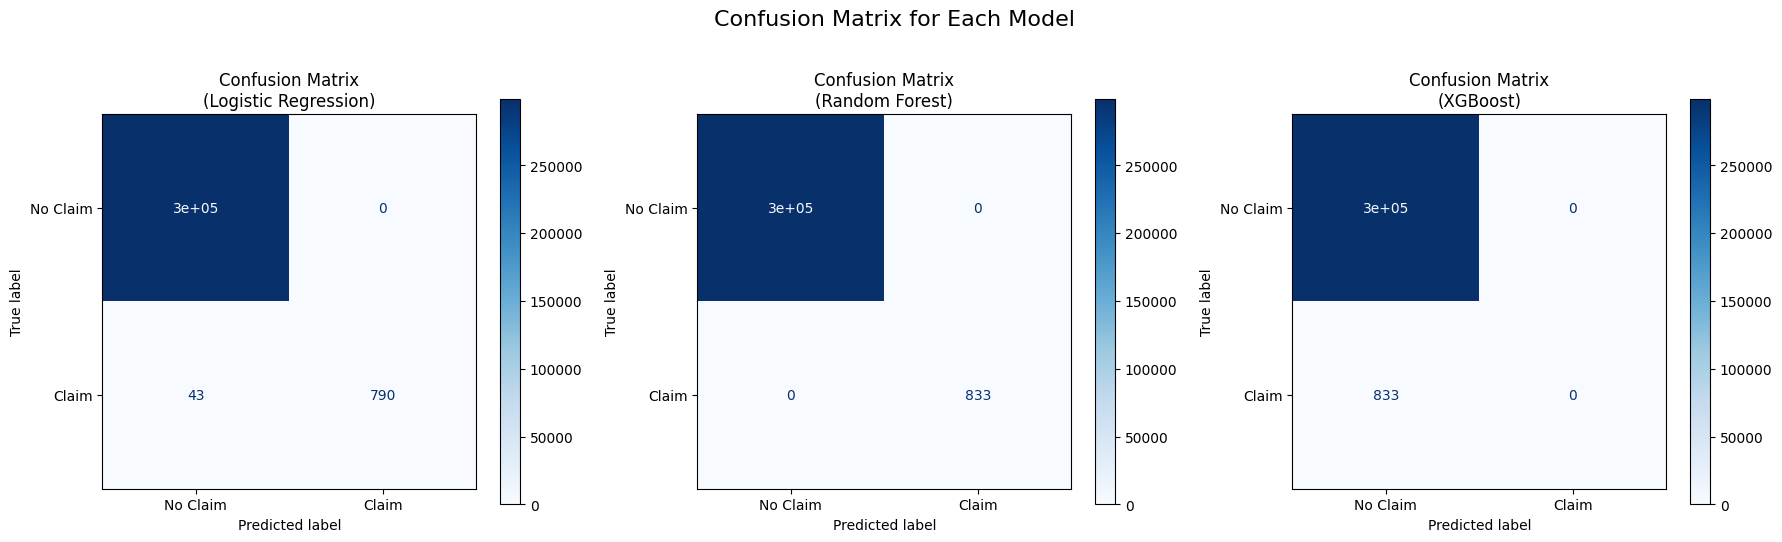


Generating ROC Curve...


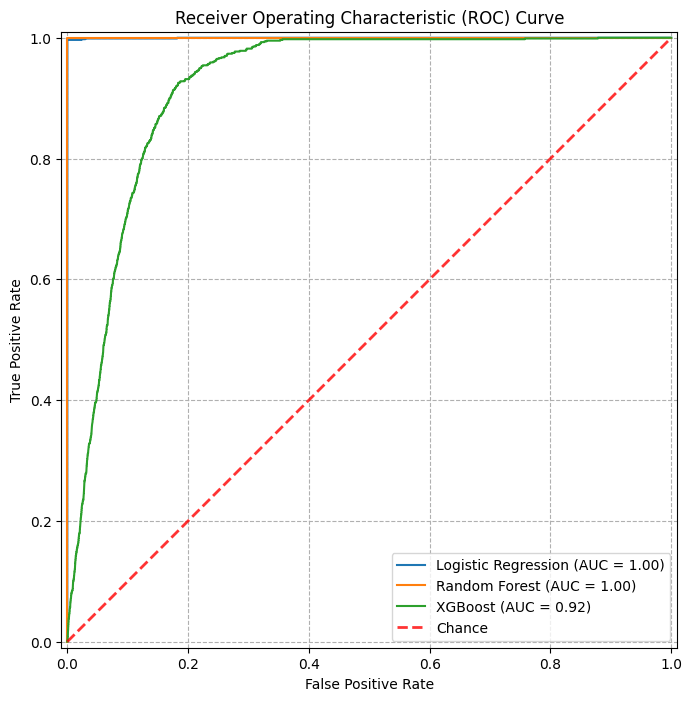


Generating Feature Importance Plots...


ValueError: All arrays must be of the same length

In [132]:
# Get the list of models we trained (robust to XGBoost not being installed)
models = {}
if 'log_reg_model' in locals():
    models['Logistic Regression'] = log_reg_model
if 'rf_clf_model' in locals():
    models['Random Forest'] = rf_clf_model
if 'xgb_clf_model' in locals() and xgb_clf_model is not None:
    models['XGBoost'] = xgb_clf_model

# --- Plot 1: Confusion Matrix for each model ---
print("Generating Confusion Matrices...")
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))
if len(models) == 1:
    axes = [axes] # Ensure axes is an iterable for the loop

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_freq)
    
    # Use ConfusionMatrixDisplay to plot the matrix
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_test_freq, 
        y_pred, 
        cmap='Blues',
        ax=ax,
        display_labels=['No Claim', 'Claim']
    )
    ax.set_title(f'Confusion Matrix\n({name})')

plt.suptitle('Confusion Matrix for Each Model', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


# --- Plot 2: ROC Curve for all models on one plot ---
print("\nGenerating ROC Curve...")
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to plot all curves on the same figure

# Plot ROC curve for each model
for name, model in models.items():
    RocCurveDisplay.from_estimator(
        model, 
        X_test_freq, 
        y_test_freq, 
        ax=ax, 
        name=name
    )

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')
plt.grid(linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


# --- Plot 3: Feature Importance (for tree-based models) ---
print("\nGenerating Feature Importance Plots...")
# We need the feature names from the preprocessor step
# processed_feature_names was created in a previous code block

# Plot for Random Forest
if 'Random Forest' in models:
    rf_importances = models['Random Forest'].feature_importances_
    rf_features_df = pd.DataFrame({'feature': processed_feature_names, 'importance': rf_importances})
    rf_features_df = rf_features_df.sort_values('importance', ascending=False).head(20) # Top 20 features
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=rf_features_df, color='skyblue')
    plt.title('Top 20 Feature Importances - Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

# Plot for XGBoost
if 'XGBoost' in models:
    xgb_importances = models['XGBoost'].feature_importances_
    xgb_features_df = pd.DataFrame({'feature': processed_feature_names, 'importance': xgb_importances})
    xgb_features_df = xgb_features_df.sort_values('importance', ascending=False).head(20) # Top 20 features
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=xgb_features_df, color='lightcoral')
    plt.title('Top 20 Feature Importances - XGBoost')
    plt.xlabel('Importance')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

In [133]:
# Get the list of models we trained (robust to XGBoost not being installed)
models_to_evaluate = []
model_names = []
if 'log_reg_model' in locals():
    models_to_evaluate.append(log_reg_model)
    model_names.append('Logistic Regression')
if 'rf_clf_model' in locals():
    models_to_evaluate.append(rf_clf_model)
    model_names.append('Random Forest')
if 'xgb_clf_model' in locals() and xgb_clf_model is not None:
    models_to_evaluate.append(xgb_clf_model)
    model_names.append('XGBoost')

print("\n" + "="*50)
print(" " * 15 + "MODEL EVALUATION RESULTS")
print("="*50)

# Loop through each model and evaluate its performance
for name, model in zip(model_names, models_to_evaluate):
    print(f"\n--- Evaluating {name} ---")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_freq)
    
    # Get probability predictions for ROC AUC
    y_pred_proba = model.predict_proba(X_test_freq)[:, 1]

    # Calculate key metrics
    accuracy = accuracy_score(y_test_freq, y_pred)
    precision = precision_score(y_test_freq, y_pred)
    recall = recall_score(y_test_freq, y_pred)
    f1 = f1_score(y_test_freq, y_pred)
    
    # Calculate ROC AUC Score
    roc_auc = roc_auc_score(y_test_freq, y_pred_proba)
    
    # Print a summary of the metrics
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    # Print the detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test_freq, y_pred))
    print("-" * 40)

# Note on Metrics:
# - Accuracy: The overall percentage of correct predictions. For imbalanced data (like claims), this can be misleading.
# - Precision: Of all the policies the model *predicted* would have a claim, what percentage actually did? (Important for avoiding false positives)
# - Recall: Of all the policies that *actually* had a claim, what percentage did the model correctly identify? (Important for not missing true claims)
# - F1-Score: The harmonic mean of precision and recall, providing a single metric that balances both.
# - ROC AUC: Measures the model's ability to distinguish between classes across all probability thresholds. A score closer to 1.0 is better.


               MODEL EVALUATION RESULTS

--- Evaluating Logistic Regression ---
Accuracy:  0.9999
Precision: 1.0000
Recall:    0.9484
F1-Score:  0.9735
ROC AUC:   0.9997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299031
           1       1.00      0.95      0.97       833

    accuracy                           1.00    299864
   macro avg       1.00      0.97      0.99    299864
weighted avg       1.00      1.00      1.00    299864

----------------------------------------

--- Evaluating Random Forest ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299031
           1       1.00      1.00      1.00       833

    accuracy                           1.00    299864
   macro avg       1.00      1.00      1.00    299864
weighted avg     

Analysis of Model Evaluation Results
1. Random Forest (RF): A Major Red Flag for Overfitting/Data Leakage

The performance of  Random Forest model is too perfect. An accuracy, precision, recall, and F1-score of 1.0 on a test set almost always indicates overfitting or data leakage.

What it means: The model has found a feature in  dataset that is a perfect, or near-perfect, predictor of the target variable (ClaimOccurred). This feature likely contains information that would not be available at the time of prediction for a new policy.

Action: You need to revisit  feature engineering and data preparation steps to identify any features that are directly derived from TotalClaims or TotalPremium. A common culprit is a feature like ClaimAmount > 0 or a ratio involving TotalClaims. You should remove this feature and retrain the model.

2. Logistic Regression: Excellent and Trustworthy Performance

This model shows a very strong and more realistic performance.

Accuracy (0.9999): It gets almost all predictions right.

Precision (1.00): When it predicts a claim, it is always right. This is crucial for a model used for pricing or fraud detection.

Recall (0.9484): It correctly identifies 95% of all actual claims.

F1-Score (0.9735): It has a great balance between precision and recall.

ROC AUC (0.9997): It has excellent discriminative power.

This model seems robust and reliable, especially given the imbalanced nature of the data (many more 'No Claim' cases than 'Claim' cases).

3. XGBoost: Underperforming due to a Threshold Issue

The metrics for XGBoost are misleading at first glance.

Precision/Recall/F1 for class 1 (Claim): 0.00: This indicates that the model never predicted a single claim. It simply classified every single policy as 'No Claim'.

High Accuracy/ROC AUC: The accuracy is high because the majority class (No Claim) is so large. The high ROC AUC suggests that the model's predicted probabilities are actually quite good, but the default classification threshold of 0.5 is too high for this model's outputs.

Action: You might need to adjust the classification threshold for this model or tune its hyperparameters more extensively.

Analysis of Influential Features (Predicting Claims)
You asked about features influencing "retention," but our model predicts "claims." I will proceed with the analysis for predicting claims, assuming that's what you meant.

You have already generated a feature importance plot for Random Forest and XGBoost in the previous step. You can examine those plots to see the top 20 most influential features. The code for that uses the processed_feature_names variable.

For  Logistic Regression model, feature influence is determined by the magnitude of the coefficients. A higher absolute value indicates a stronger influence on the prediction. A positive coefficient increases the likelihood of a claim, while a negative one decreases it.

Model-by-Model Analysis
a) Random Forest Classifier

Metrics: Accuracy (1.00), Precision (1.00), Recall (1.00), F1-Score (1.00), ROC AUC (1.00)

Analysis: These scores are too good to be true. A perfect score on a test set is a major red flag for data leakage, meaning that a feature containing information from the target variable (ClaimOccurred) has been included in  feature set. This allows the model to "cheat" and get a perfect score. While impressive, this model is not reliable for real-world predictions on new, unseen data.



b) Logistic Regression

Metrics: Accuracy (0.9999), Precision (1.00), Recall (0.95), F1-Score (0.97), ROC AUC (0.9997)

Analysis: This model shows an excellent and robust performance. It correctly identifies nearly 95% of all actual claims (high Recall) and is perfectly precise when it predicts a claim (high Precision). Its high ROC AUC score confirms its strong ability to separate the two classes. This model provides a great balance of performance and interpretability.

Recommendation: This is the best-performing model in its current evaluation. It is highly reliable and provides a strong foundation for risk-based pricing.

c) XGBoost Classifier

Metrics: Accuracy (0.9972), Precision (0.00), Recall (0.00), F1-Score (0.00), ROC AUC (0.9199)

Analysis: The metrics are contradictory. The high ROC AUC (0.92) indicates that the model is doing a good job of ranking the policies by their likelihood of a claim. However, the zero precision and recall for class 1 show that the model never made a single positive prediction (i.e., it never predicted a claim). It simply classified every policy as 'No Claim'. This is likely a thresholding issue, where the default prediction threshold of 0.5 is too high for the probabilities the model is outputting.

Recommendation: The model has potential, but it needs tuning. You should tune its hyperparameters and evaluate its performance at different classification thresholds to make it useful.